In [ ]:
# default_exp single_RL_walker

In [17]:
#export
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from rl_optimal_search.single_LW_walker import isBetween_c_Vec, isBetween

In [18]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Environment

In [19]:
#export
class target_env():
    def __init__(self,
                 Nt = 1000,
                 L = 200,
                 at = 1,
                 ls = 2,
                 agent_step = 1,
                 boundary_condition = 'periodic'):
        
        self.Nt = Nt
        self.L = L
        self.at = at
        self.ls = ls
        self.boundary_condition = boundary_condition
        
        self.init_env()
        
        self.agent_step = agent_step 
        self.current_direction = torch.rand(1)*2*np.pi
        
        self.agent_state = 0
        
    def init_env(self):
        self.target_positions = torch.rand(self.Nt, 2)*self.L
        self.agent_pos = torch.rand(2)*self.L
        self.previous_pos = self.agent_pos.clone()
        
    def update_pos(self, direction):        
            
        # Save previous position to check if crossing happened
        self.previous_pos = self.agent_pos.clone()
            
        self.agent_pos[0] = self.agent_pos[0] + self.agent_step*np.cos(direction)
        self.agent_pos[1] = self.agent_pos[1] + self.agent_step*np.sin(direction)
        
        self.check_bc()
                
    def check_encounter(self):
        encounters = isBetween_c_Vec(self.agent_pos, self.previous_pos, self.target_positions, epsilon = self.at)
        
        if sum(encounters) > 0:   
            distance_previous_pos = np.sqrt((self.agent_pos[0]-self.target_positions[:, 0])**2 + (self.agent_pos[1]-self.target_positions[:, 1])**2)            
            
            # checking which encountered point is closer to previous position
            min_distance_masked = np.argmin(distance_previous_pos[encounters])
            first_encounter = np.arange(self.Nt)[encounters][min_distance_masked]
            
            # If there was encounter, we reset direction and change position of particle to (pos target + ls)
            self.current_direction = np.random.uniform(low = 0, high = 2*np.pi)
            self.agent_pos[0] = self.target_positions[first_encounter, 0] + self.ls*np.cos(self.current_direction)
            self.agent_pos[1] = self.target_positions[first_encounter, 1] + self.ls*np.sin(self.current_direction)
            
            # Update the state of the agent
            self.agent_state = 0
            
            self.check_bc()
            
            return 1
        
        else: return 0
        
    def check_bc(self): 
        if self.boundary_condition == 'reflectant':
            while torch.max(self.agent_pos) > self.L or torch.min(self.agent_pos)< 0: 
                self.agent_pos[self.agent_pos > self.L] = self.agent_pos[self.agent_pos > self.L] - 2*(self.agent_pos[self.agent_pos > self.L] - self.L)
                self.agent_pos[self.agent_pos < 0] = - self.agent_pos[self.agent_pos < 0]


        elif self.boundary_condition == 'periodic':
            while torch.max(self.agent_pos) > self.L or torch.min(self.agent_pos)< 0: 
                self.agent_pos[self.agent_pos > self.L] = self.agent_pos[self.agent_pos > self.L] - self.L
                self.agent_pos[self.agent_pos < 0] = self.L + self.agent_pos[self.agent_pos < 0]  
            
        
    

In [ ]:
env = target_env(Nt = 500, L = 100, boundary_condition = 'reflectant')
T = 1000
pos = torch.zeros(T, 2)
pos[0,:] = env.agent_pos

encountered = []
for t in range(1, T):
    
    if torch.rand(1) > 0.9: action = 1
    else: action = 0
        
    env.update_pos(action)
    touch = env.check_encounter()
    
    if touch is not None:
        try: encountered = torch.vstack((encountered, touch))
        except: encountered = touch
    
    
    pos[t,:] = env.agent_pos
        
    
# encountered = np.array(encountered)

In [ ]:
fig, ax = plt.subplots(figsize = ( 10, 10))
ax.plot(pos[:, 0], pos[:, 1], label = 'Agent Position')
ax.scatter(env.target_positions[:, 0], env.target_positions[:, 1], c = 'C1', marker='.')
ax.scatter(encountered[:, 0], encountered[:, 1], c = 'C2', label = 'Targets encountered')
ax.legend()

# Q-table

In [20]:
class Qtable_constraints:
    
    def __init__(self, state_space,
                 action_space,
                 alpha,
                 gamma, 
                 egreedy,
                 egreedy_decay = 0.999,
                 egreedy_min = 0.1):
        
        self.state_space = state_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.egreedy = egreedy        
        self.egreedy_decay = egreedy_decay
        self.egreedy_min = egreedy_min
        
        self.Q = np.zeros([self.state_space, self.action_space])
        self.V = np.zeros(self.state_space)
        
        
    def act(self, s):
        
        if np.random.rand() < self.egreedy:
            a = np.argmax(np.random.randn(1,self.action_space)) 
            self.action_greedy = False
        else:
            a = np.argmax(self.Q[s,:])
            self.action_greedy = True
          
        return a
      
    def update_Q(self, s, s1, a, r):        
        #Update Q-Table with new knowledge
        self.Q[s,a] = self.Q[s,a] + self.alpha*(r + self.gamma*np.max(self.Q[s1,:]) - self.Q[s,a])
        
    def update_V(self, s, reward):        
        self.V[s] = self.V[s] + reward

# Agent #1

In [21]:
class step_by_step_agent():
    ''' At every time step, the agent decides if it rotates or continues in the current direction'''
    
    def __init__(self, policy, state_space):        
        ''' Class constructor'''
        self.policy = policy
        
        self.current_direction = torch.rand(1)*2*np.pi
        self.agent_state = 0
        
        self.state_space = state_space
        
        
    
    def act(self):
        
        state = np.argwhere((self.state_space - self.agent_state) <= 0)[-1]
        
        action = self.policy.act(state)        
    
        # If the agent changes direction   
        if action == 1:          
            self.current_direction = torch.rand(1)*2*np.pi
            self.agent_state = 0
        
        self.agent_state += 1        
        
        return action, self.current_direction

In [22]:
#%% ---------------------------------------------------------------------------
# Parameters
# -----------------------------------------------------------------------------
episodes = 100
time_ep = 900
# Learning_parameters
learning_rate = 0.01
egreedy = 1
egreedy_decay = 0.999
egreedy_min = 0.1

time_bins = min(time_ep, 1000)
state_space = np.arange(time_bins)#np.linspace(0, time_ep, time_bins)

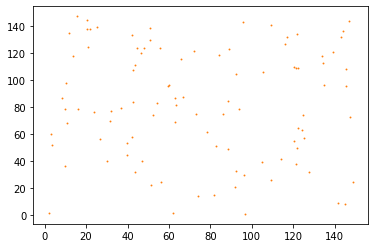

In [23]:
qtable = Qtable_constraints(state_space = time_bins,
                           action_space = 2,
                           alpha = 0.8, 
                           gamma = 0.95, 
                           egreedy= egreedy)

agent = step_by_step_agent(policy = qtable,
                           state_space = state_space)

Nt = 1000
L = 150 
at = 1
Nt = 100

env = target_env(Nt = Nt, L = L, boundary_condition = 'periodic', at = at)
plt.scatter(env.target_positions[:, 0], env.target_positions[:, 1], c = 'C1', marker='.', s = np.pi*env.at**2)

In [24]:
rewards = torch.zeros(episodes, time_ep)
steps = []
step_r = []
pos_agent = np.zeros((episodes, time_ep, 2))

for e in tqdm(range(episodes)):
    
    env.init_env()
    step_length = [1]
    
    for t in (range(time_ep)):
        
        pos_agent[e, t, :] = env.agent_pos.clone()    
        
        
        state = int(np.argwhere((agent.state_space - agent.agent_state) <= 0)[-1])
        
        action, direction = agent.act()
        
        env.update_pos(direction)
        
        
        reward = env.check_encounter()
            
        # Save info
        rewards[e, t] = reward
        
        if reward == 1:
            step_r.append(state)
            agent.agent_state = 0
        
        if action == 0:
            step_length[-1] += 1
        elif action == 1 or reward == 1:
            step_length.append(1)            

        # update q-matrix
        next_state = int(np.argwhere((agent.state_space - agent.agent_state) <= 0)[-1])
        agent.policy.update_Q(state, next_state, action, reward)            
        agent.policy.update_V(next_state, reward) 
        
        if agent.policy.egreedy > egreedy_min:
            agent.policy.egreedy *= egreedy_decay

            
    steps.append(step_length)
    

  0%|          | 0/100 [00:00<?, ?it/s]

### Parallel training

In [7]:
from tqdm import tqdm as tqdm_console

def optimal_training(episodes, time_ep, Nt, L, at, ls):
    num_agents = 20
    rewards = torch.zeros(num_agents, episodes, time_ep)
    
    for age in tqdm_console(range(num_agents)):
        
        '''  Setting env and agent '''
        time_bins = min(time_ep, 1000)
        state_space = np.arange(time_bins)

        env = target_env(Nt = Nt, L = L, at = at, ls = ls)

        qtable = Qtable_constraints(state_space = time_bins,
                                    action_space = 2,
                                    alpha = 0.8, 
                                    gamma = 0.95, 
                                    egreedy= 1,
                                    egreedy_decay = 0.999,
                                    egreedy_min = 0.1)    


        agent = step_by_step_agent(policy = qtable,
                                   state_space = state_space)

        ''' Savers ''' 

        step_lengths = []
        state_when_rewarded = []
        pos_agent = np.zeros((episodes, time_ep, 2))

        for e in (range(episodes)):

            env.init_env()
            s_length = [1]

            for t in (range(time_ep)):

                pos_agent[e, t, :] = env.agent_pos.clone()    

                state = int(np.argwhere((agent.state_space - agent.agent_state) <= 0)[-1])

                action, direction = agent.act()

                env.update_pos(direction)


                reward = env.check_encounter()

                # Save info
                rewards[age, e, t] = reward

                if reward == 1:            
#                     state_when_rewarded.append(state)
                    agent.agent_state = 0

                if action == 0:
                    s_length[-1] += 1
                elif action == 1 or reward == 1:
                    s_length.append(1)            

                # update q-matrix
                if agent.policy.action_greedy:
                    next_state = int(np.argwhere((agent.state_space - agent.agent_state) <= 0)[-1])
                    agent.policy.update_Q(state, next_state, action, reward)            
                    agent.policy.update_V(next_state, reward) 

                    if agent.policy.egreedy > agent.policy.egreedy_min:
                        agent.policy.egreedy *= agent.policy.egreedy_decay


#             step_lengths.append(s_length)
        
        try:
            q_output += agent.policy.Q 
        except: 
            q_output = agent.policy.Q
    
    
    dic_results = {'rewards' : rewards,
#                    'step_lengths': np.concatenate(step_lengths),
                   'state_when_rewarded': state_when_rewarded,
                   'Q_matrix': agent.policy.Q}
    
    return dic_results

In [8]:
from joblib import Parallel, delayed

num_ls = 10
lss = np.linspace(0.3, 1, num_ls)

L = 150 
at = 1
Nt = 100
episodes = 1000
time_ep = 1000

info = Parallel(n_jobs=num_ls)(delayed (optimal_training) (episodes, time_ep, Nt, L, at, ls)
                           for ls in lss)


In [29]:
info[1]['Q_matrix']

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

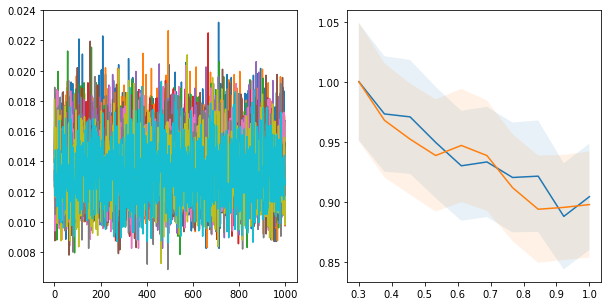

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

late_rew, total_rew = [], []
late_var, total_var = [], []
for info_agent in info:
    
    ax[0].plot(info_agent['rewards'].mean(0).sum(1)/time_ep);
    total_rew.append(float(info_agent['rewards'].mean(0)[:200,:].mean()))
    late_rew.append(float(info_agent['rewards'].mean(0)[-200:,:].mean()))
    
    
    total_var.append(float(info_agent['rewards'].mean(0)[:100,:].var()))
    late_var.append(float(info_agent['rewards'].mean(0)[-100:,:].var()))
    
total_rew = np.array(total_rew)
late_rew = np.array(late_rew)

ax[1].plot(lss, total_rew/max(total_rew))
ax[1].fill_between(lss, (total_rew-total_var)/max(total_rew), (total_rew+total_var)/max(total_rew), alpha = 0.1)
ax[1].plot(lss, late_rew/max(late_rew))
ax[1].fill_between(lss, (late_rew-late_var)/max(late_rew), (late_rew+late_var)/max(late_rew), alpha = 0.1)

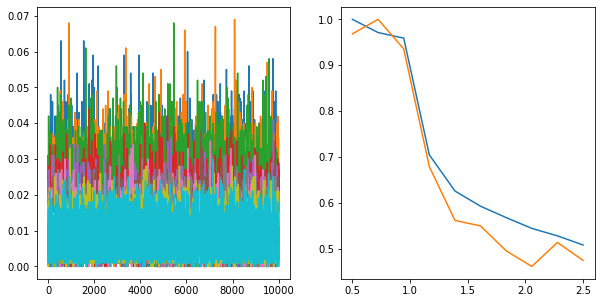

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

late_rew, total_rew = [], []
for info_agent in info:
    
    ax[0].plot(info_agent['rewards'].sum(1)/time_ep);
    total_rew.append(float(info_agent['rewards'].mean()))
    late_rew.append(float(info_agent['rewards'][-100:,:].mean()))

total_rew = np.array(total_rew)
late_rew = np.array(late_rew)

ax[1].plot(lss, total_rew/max(total_rew))
ax[1].plot(lss, late_rew/max(late_rew))

In [12]:
info_agent['Q_matrix']

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

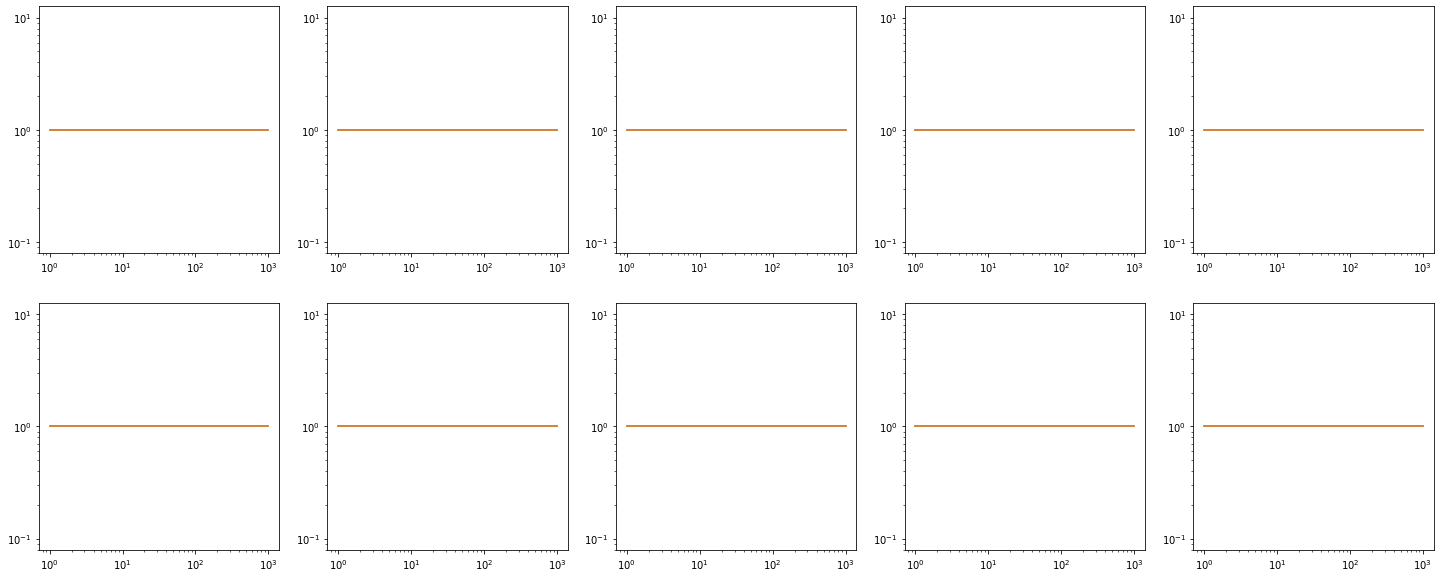

In [11]:
fig, axs = plt.subplots(2, 5, figsize = (25, 10))

for info_agent, ax in zip(info, axs.flatten()):
    ax.loglog(np.arange(1, len(info_agent['Q_matrix'])+1), info_agent['Q_matrix'][:, 0]+1, label = 'stay');
    ax.plot(np.arange(1, len(info_agent['Q_matrix'])+1), info_agent['Q_matrix'][:, 1]+1, label = 'rotate');


In [26]:
time_bins = min(time_ep, 1000)
state_space = np.arange(time_bins)
qtable = Qtable_constraints(state_space = time_bins,
                                action_space = 2,
                                alpha = 0.8, 
                                gamma = 0.95, 
                                egreedy= 1,
                                egreedy_decay = 0.999,
                                egreedy_min = 0.1)    


agent = step_by_step_agent(policy = qtable,
                           state_space = state_space)
agent.policy.egreedy = 0

T = 1000; N = 500

pos = np.zeros((len(lss), N, T, 2))

for idxls, (info_agent, LS) in enumerate(zip(info, lss)):
    
    q = info_agent['Q_matrix'].copy()
    agent.policy.Q = q


    for n in tqdm(range(N)):
        for t in (range(1, T)):

            # trained agent
            _, direction = agent.act()

            pos[idxls, n, t, 0] = pos[idxls, n, t-1, 0] + np.cos(direction)
            pos[idxls, n, t, 1] = pos[idxls, n, t-1, 1] + np.sin(direction)
            
#     msd = (pos[:,:, 0]**2).mean(0)
#     plt.loglog(msd, label = f'ls = {LS}')
            

        

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

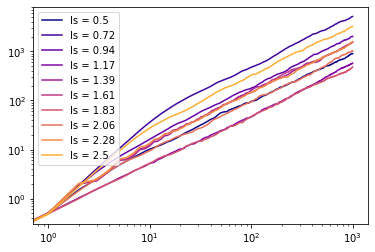

In [25]:
colors=plt.cm.plasma(np.linspace(0,1,len(lss)+2))

for p, c, LS in zip(pos, colors, lss):
    msd = (p[:,:, 0]**2).mean(0)
    plt.loglog(msd, label = f'ls = {np.round(LS, 2)}', c = c)
plt.legend()    

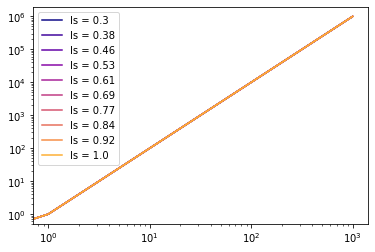

In [27]:
colors=plt.cm.plasma(np.linspace(0,1,len(lss)+2))

save_last = []
for p, c, LS in zip(pos, colors, lss):
    msd = (p[:,:, 0]**2).mean(0)
    save_last.append(msd[-1])
    plt.loglog(msd, label = f'ls = {np.round(LS, 2)}', c = c)
plt.legend()    

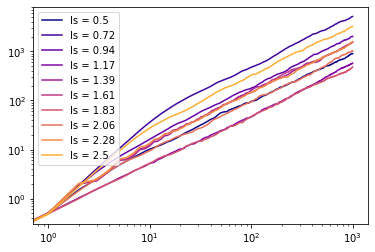

In [25]:

plt.plot()

In [25]:
colors=plt.cm.plasma(np.linspace(0,1,len(lss)+2))

for p, c, LS in zip(pos, colors, lss):
    msd = (p[:,:, 0]**2).mean(0)
    plt.loglog(msd, label = f'ls = {np.round(LS, 2)}', c = c)
plt.legend()    

NameError: name 'pos' is not defined

# Agent 2
This is an multiarmed bandit like agent, which does not have any state and just chose actions

In [5]:
class pred_num_steps_agent():
    ''' This agent predicts the number of steps to be done before changing direction'''
    
    def __init__(self, policy, state_space):        
        ''' Class constructor'''
        self.policy = policy
        
        self.current_direction = torch.rand(1)*2*np.pi
        self.agent_state = 0
        
        self.state_space = state_space
        
        
    
    def act(self):
        
        state = np.argwhere((self.state_space - self.agent_state) <= 0)[-1]
        
        action = self.policy.act(state)        
    
        # If the agent changes direction   
        if action == 1:          
            self.current_direction = torch.rand(1)*2*np.pi
            self.agent_state = 0
        
        self.agent_state += 1        
        
        return action, self.current_direction